In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import optimize
import umodel as unf

import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

In [2]:
# Loading data cos(n, -)
with open('../data/CosThetaNminus/asimov_spinCorrelation.json', 'r') as read_file:
    dm = np.array(json.load(read_file))
    
with open('../data/CosThetaNminus/resmat_spinCorrelation.json', 'r') as read_file:
    rm = np.array(json.load(read_file))

    
# Loading data cos(n, +)
with open('../data/CosThetaNplus/asimov_spinCorrelation.json', 'r') as read_file:
    dp = np.array(json.load(read_file))
    
with open('../data/CosThetaNplus/resmat_spinCorrelation.json', 'r') as read_file:
    rp = np.array(json.load(read_file))

    
# Loading data correlations between the two observables
with open('../data/correlation_matrix_CosThetaNplus_CosThetaNminus_bins.json', 'r') as read_file:
    corrDict = json.load(read_file)

n, p = rm.shape[0], rp.shape[0]
corr = np.zeros((n+p, n+p))
for i, (iName, line) in enumerate(corrDict.items()):
    for j, (jName, c) in enumerate(line.items()):
        corr[i, j] = c

In [3]:
def showMat(m, percent=False):
    plt.matshow(m, cmap='Wistia')
    msg = '{:.0e}'
    if percent:
        msg = '{:.0f}'
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(i, j, msg.format(m[j, i]), va='center', ha='center', fontsize=12)

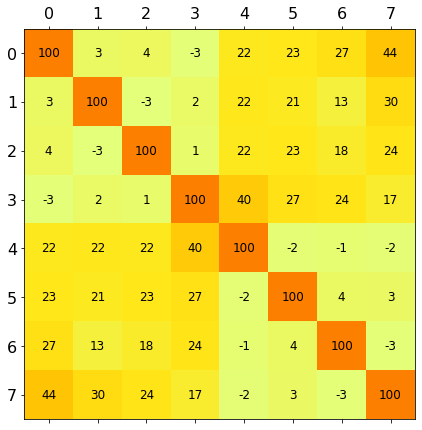

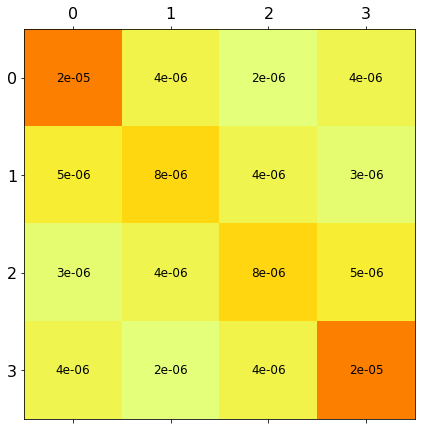

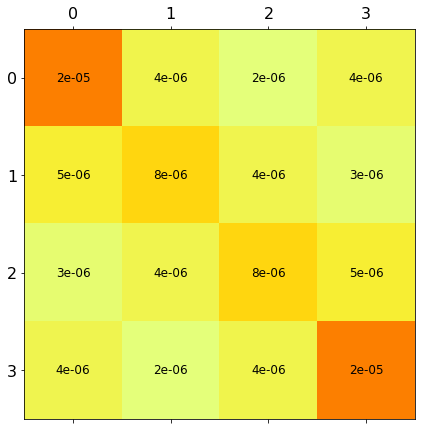

In [4]:
showMat(corr*100, True)
showMat(rm)
showMat(rp)

In [5]:
def plotResult(xEdges, valueErrors):
    
    '''
    This function plot the post-fit unfolded bins 
    versus the unfolded observables values.
    
    xEdges: 1D array with edges of observable values
    valueErrors: list of 2D array of shape (N, 3) with N POIs
                 measurment with central value, negative and 
                 positive error.
    '''
    
    # Plot the result
    plt.figure(figsize=(15, 6))

    # x-data for binned-like plotting
    xUp, xDown = xEdges[1:], xEdges[:-1]
    xCenter = (xUp + xDown) / 2
    
    # Labels
    xlabels = ['cos($\\theta^{+}_{n}$)', 'cos($\\theta^{-}_{n}$)']
    
    for i, distri in enumerate(valueErrors):
    
        # y-data
        vals = distri[:, 0]
        errn = distri[:, 1]
        errp = distri[:, 2]

        # Plot
        plt.subplot(1, 2, i+1)
        plt.plot(xCenter, vals, 'o', markersize=10)
        plt.hlines(y=vals, xmin=xDown, xmax=xUp, color='tab:blue')
        plt.vlines(x=xCenter, ymin=vals-errn, ymax=vals+errp, color='tab:blue')
        plt.ylabel('Reco Yields')
        plt.xlabel(xlabels[i])
        plt.ylim(10e3, 30e3)
        plt.tight_layout()

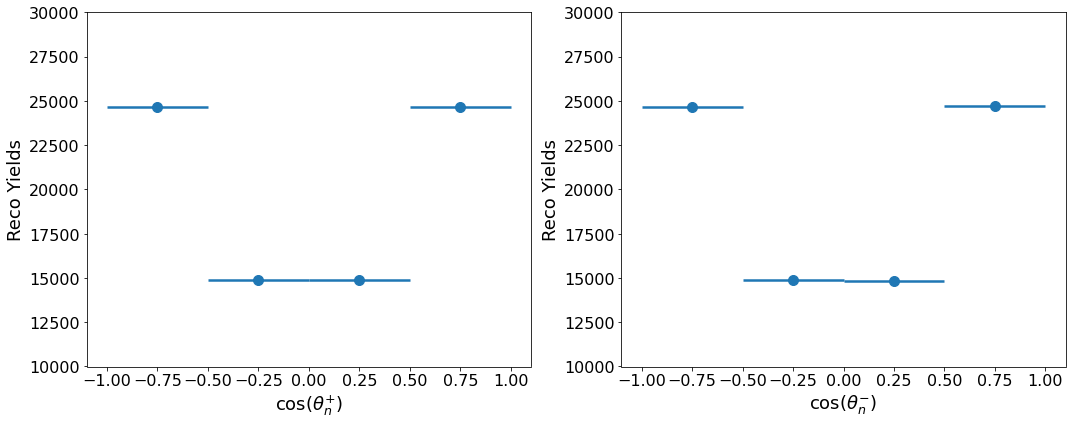

In [6]:
Xs = np.array([-1.0, -0.5, 0, 0.5, 1.0])
valueErrors = []

valDM = np.zeros(shape=(dm.shape[0], 3))
valDM[:, 0] = dm
valDM[:, 1] = np.sqrt(dm)
valDM[:, 2] = np.sqrt(dm)
valueErrors.append(valDM)

valDP = np.zeros(shape=(dm.shape[0], 3))
valDP[:, 0] = dp
valDP[:, 1] = np.sqrt(dp)
valDP[:, 2] = np.sqrt(dp)
valueErrors.append(valDP)

plotResult(Xs, valueErrors)

In [7]:
Ds = [dp, dm]
Rs = [rp, rm]
mCorr = unf.model(Ds, Rs, corr)
m = unf.model(Ds, Rs, corr=np.diag([1]*8))

In [8]:
# Run with correlation
BsCorr, _ = mCorr.unfold()
POIsCorr  = mCorr.postFitUncerPOIs()

In [9]:
# Run without correlations
Bs, _ = m.unfold()
POIs = m.postFitUncerPOIs()

In [10]:
# Comparing result w/ and w/o corr from direct unfolding (full minimzation, only central values)
# --> no differences
bpCorr = BsCorr[0]
bmCorr = BsCorr[1]
bp = Bs[0]
bm = Bs[1]
print((bpCorr-bp)/bp)
print((bmCorr-bm)/bm)

[0. 0. 0. 0.]
[0. 0. 0. 0.]


In [11]:
# Comparing results w/ and w/o corr from profile LH
# --> differences from ~1% to 20% level!
POIsCorr = np.concatenate(POIsCorr)
POIs = np.concatenate(POIs)
relDiff = (POIsCorr-POIs) / POIs[:, 0, np.newaxis]
print( relDiff[:, 0] )

[-2.05184153e-04 -5.51714751e-05  3.15515783e-03 -2.05184153e-04
  0.00000000e+00 -5.51714751e-05 -5.51714751e-05  2.87257814e-03]


In [12]:
# Comparing results between unfolded and profile, w/o corr
# --> no differences
for m1, m2 in zip(POIs, np.concatenate([bp, bm])):
    print((m1[0] - m2)/m1[0])

0.00010259207638850984
0.0001577578913036634
0.00015775789130376746
0.00010259207638850253
0.00010259207638860135
0.00015775789130375643
0.00015775789130369883
0.00010259207638850277


In [13]:
# Comparing results between unfolded and profiled, w/ corr
# --> large differences (from ~3% to 25%)!
for m1, m2 in zip(POIsCorr, np.concatenate([bpCorr, bmCorr])):
    print((m1[0] - m2)/m1[0])

-0.00010261313097685313
0.00010259207638855619
0.003302495821839609
-0.00010261313097684581
0.00010259207638860135
0.00010259207638852724
0.00010259207638852709
0.0029666482862553876


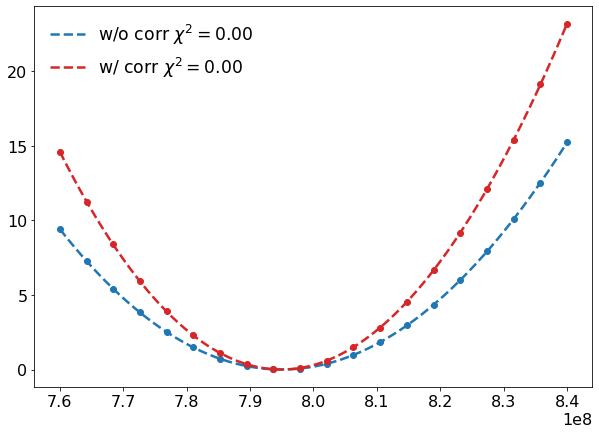

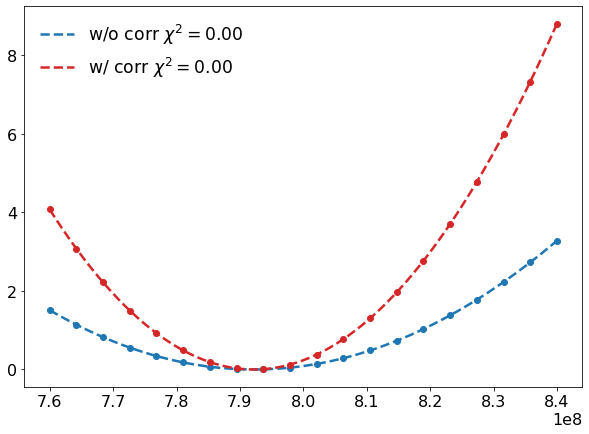

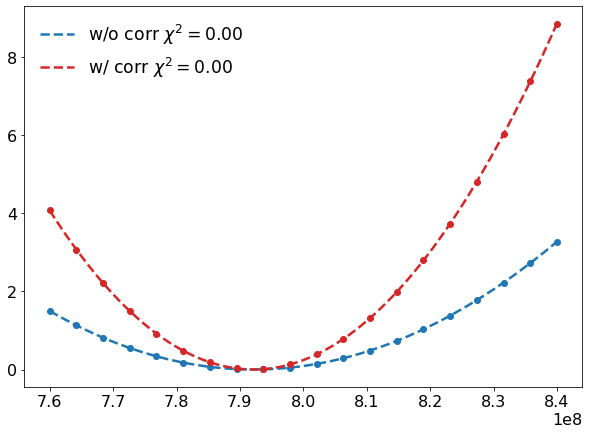

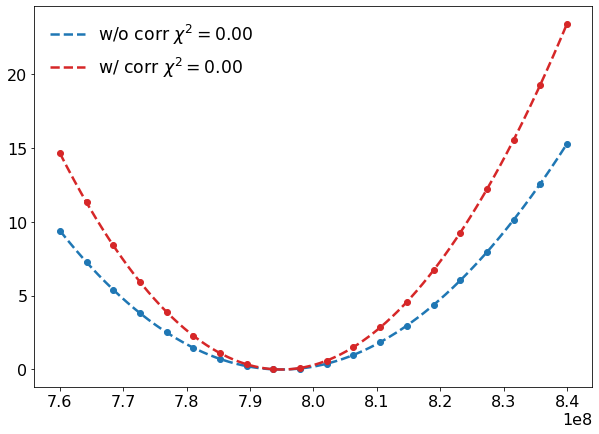

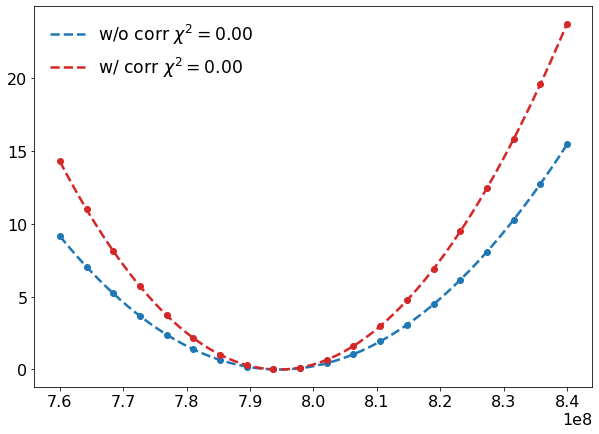

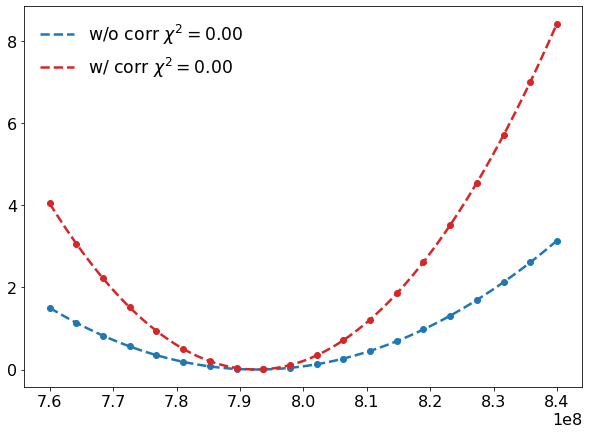

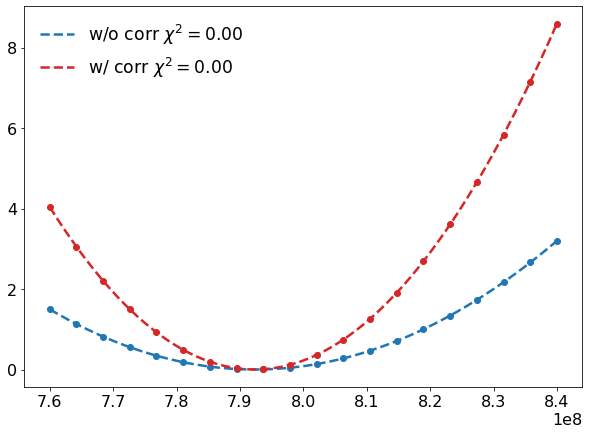

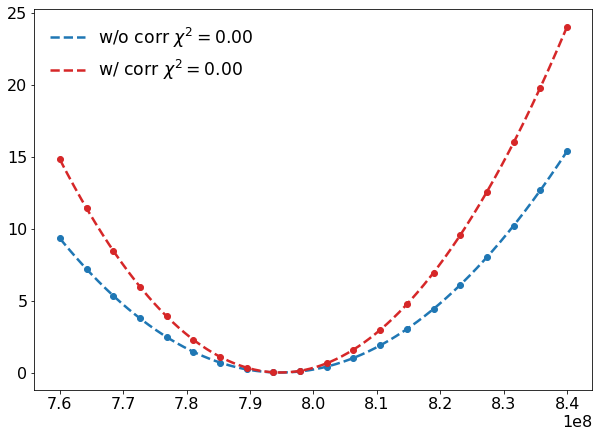

In [19]:
for i in range(8):
    plt.figure()
    m.plotProfile(i, POImin=0.76e9, POImax=0.84e9, nScan=20, label='w/o corr', color='tab:blue')
    mCorr.plotProfile(i, POImin=0.76e9, POImax=0.84e9, nScan=20, label='w/ corr', color='tab:red')

In [20]:
def plotResult(xEdges, postFitPOIs1, postFitPOIs2):
    
    '''
    This function plot the post-fit unfolded bins 
    versus the unfolded observables values.
    
    xEdges: 1D array with edges of observable values
    postFitPOIs: 2D array of shape (N, 3) with N POI measurment
                 with central value, negative and positive error.
    '''
    
    # Plot the result
    plt.figure(figsize=(15, 5))

    # x-data for binned-like plotting
    xUp, xDown = xEdges[1:], xEdges[:-1]
    xCenter = (xUp + xDown) / 2
    
    # Labels
    xlabels = ['cos($\\theta^{+}_{n}$)', 'cos($\\theta^{-}_{n}$)']
    
    for i, (distri1, distri2) in enumerate(zip(postFitPOIs1, postFitPOIs2)):
    
        # y-data
        vals1 = distri1[:, 0]
        errn1 = distri1[:, 1]
        errp1 = distri1[:, 2]
        vals2 = distri2[:, 0]
        errn2 = distri2[:, 1]
        errp2 = distri2[:, 2]

        # Plot
        plt.subplot(1, 2, i+1)
        plt.plot(xCenter-0.05, vals1, 'o', markersize=10)
        #plt.hlines(y=vals1, xmin=xDown, xmax=xUp, color='tab:blue')
        plt.vlines(x=xCenter-0.05, ymin=vals1-errn1, ymax=vals1+errp1, color='tab:blue', label='w/o corr')
        plt.legend()
        
        plt.plot(xCenter+0.05, vals2, 'o', markersize=10, color='tab:red')
        #plt.hlines(y=vals2, xmin=xDown, xmax=xUp, color='tab:red')
        plt.vlines(x=xCenter+0.05, ymin=vals2-errn2, ymax=vals2+errp2, color='tab:red', label='w/ corr')
        plt.ylabel('Unfolded Yields')
        plt.xlabel(xlabels[i])
        plt.ylim(7e8, 9e8)
        plt.legend()
        
        
def plotErrorBarRatio(xEdges, postFitPOIs1, postFitPOIs2):
    # Plot the result
    plt.figure(figsize=(15, 5))

    # x-data for binned-like plotting
    xUp, xDown = xEdges[1:], xEdges[:-1]
    xCenter = (xUp + xDown) / 2
    
    # Labels
    xlabels = ['cos($\\theta^{+}_{n}$)', 'cos($\\theta^{-}_{n}$)']
    
    for i, (distri1, distri2) in enumerate(zip(postFitPOIs1, postFitPOIs2)):
    
        # y-data
        bar1 =  distri1[:, 2] + distri1[:, 1]
        bar2 =  distri2[:, 2] + distri2[:, 1]

        # Plot figure
        plt.subplot(1, 2, i+1)
        
        # Plot data
        plt.plot(xCenter, bar2 / bar1, markersize=10, marker='o')
        
        # Plot cosmetics
        plt.ylabel('Error Bar Ratio')
        plt.xlabel(xlabels[i])
        plt.ylim(0.0, 2.0)

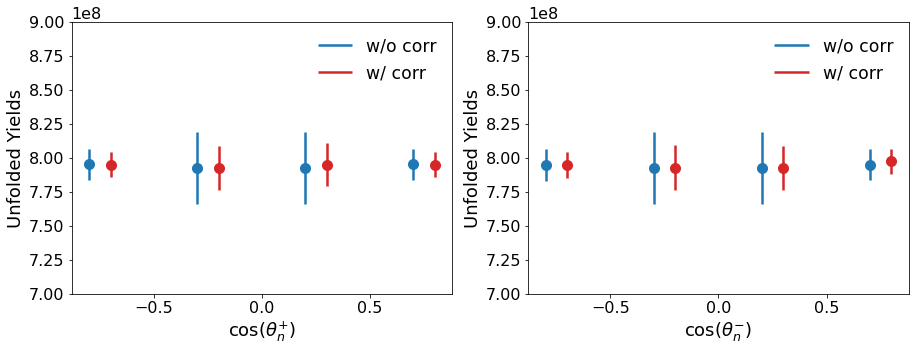

In [21]:
Xs = np.array([-1.0, -0.5, 0, 0.5, 1.0])
plotResult(Xs, m._array2list(POIs), m._array2list(POIsCorr))

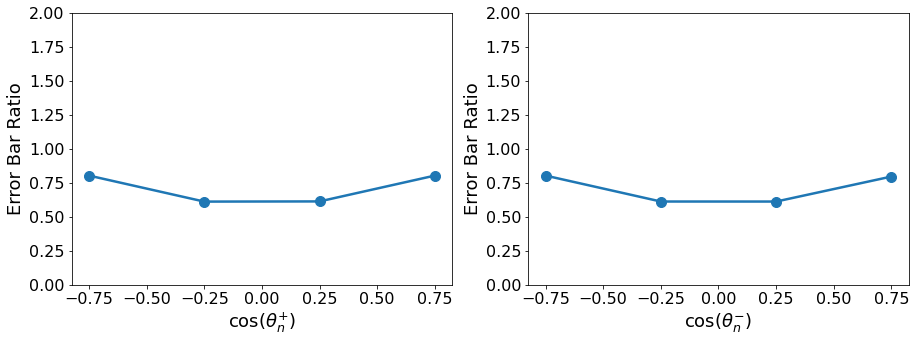

In [22]:
plotErrorBarRatio(Xs, m._array2list(POIs), m._array2list(POIsCorr))

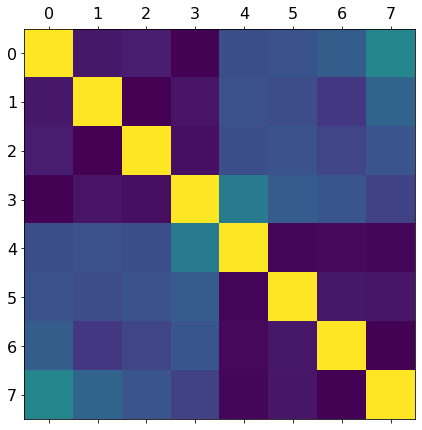

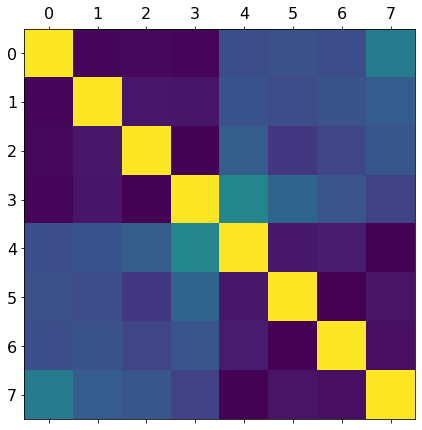

In [27]:
# Now to the same thing but inversing the two observables
D2s = [dm, dp]
R2s = [rm, rp]

# New correlation matrix - re-arranged
corr2 = corr.copy()
for i in range(4):
    for j in range(4):  
        corr2[i, j] = corr[i+4, j+4]
        corr2[i+4, j+4] = corr[i, j]
        corr2[i, j+4] = corr[i+4, j]
        corr2[i+4, j] = corr[i, j+4]

plt.matshow(corr)
plt.matshow(corr2)

m2Corr = unf.model(D2s, R2s, corr2)
m2 = unf.model(D2s, R2s, corr=np.diag([1]*8))

In [25]:
Bs = [
    np.array([ 1.51049192e+10,  1.51069154e+10,  1.51071235e+10,  1.51046997e+10]), 
    np.array([-6.36546195e+08, -6.33778546e+08, -6.33710702e+08, -6.36499063e+08]),
]
m2Corr.NLL(Bs)
mCorr.NLL(Bs[::-1])

res2, nll2 = m2Corr.unfold()
res1, nll1 = mCorr.unfold()

for i in range(2):
    print(res1[i])
    print(res2[i], '\n') 

[7.94973897e+08 7.92206249e+08 7.92138404e+08 7.94926765e+08]
[79213840.44843295 79213840.44843295 79213840.44843338 79213840.44843338] 

[7.94558444e+08 7.92562301e+08 7.92354207e+08 7.94778021e+08]
[7.94973897e+09 7.94973897e+09 7.94973897e+09 7.94973897e+09] 



In [ ]:
#POIs2Corr = m2Corr.postFitUncerPOIs()
#POIs2     = m2.postFitUncerPOIs()